## StructureBoost - Exploration of Weather data in California Counties


This notebook gives a longer exploration of the California County weather data.  This is a simple dataset which is very useful for instruction.  One advantage of this dataset is that we essentially "know" the right answer.  This allows us to compare performances of various models and settings thereof when we only have a small amount of training data.

We dive into the data to show the patterns and demonstrate how StructureBoost can provide superior prediction by exploiting the structure in categorical variables.





## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import log_loss, roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split
import copy

import structureboost as stb

# CatBoost is used later as a comparison
# can be commented out if unavailable (and skip the sections that use it)
import catboost as cb


pd.set_option("display.max_rows",999)
pd.set_option("display.max_columns",999)

from IPython.display import Image

stb.__version__

'0.0.4'

## Load Data

In [2]:
# Load the data and look at a few random data points
df_ca_PRCP = pd.read_csv('data/CA_County_PRCP.csv')
df_ca_PRCP.sample(5)

,county,month,DATE,STATION,PRCP,rained,county_DATE
15976,Amador,12,2004-12-31,USC00048713,1.64,1,Amador___2004-12-31
278204,San_Luis_Obispo,1,2007-01-24,USC00047933,0.00,0,San_Luis_Obispo___2007-01-24
117331,Lake,12,2010-12-10,US1CALK0008,0.00,0,Lake___2010-12-10
253983,San_Bernardino,12,2018-12-07,US1CASR0014,0.51,1,San_Bernardino___2018-12-07
413842,Yuba,8,2013-08-26,USC00048606,0.00,0,Yuba___2013-08-26


## Data Exploration
The data contains observations of precipitation at various weather stations across California, provided by NOAA.  We have filtered the data to contain only one observation per day per county (though some counties have more observations than others). 

Our goal for this exercise is to find the probabiliy of rain in a particular county in a particular month.  Since we have so many observations, we essentially "know" the correct answer.  There are only 12 months and 58 counties, and for each of these 12 x 58 = 696 combinations, we have at least 450 observations.  Therefore we know the true probability of rain for each month/county combination to a reasonable degree of accuracy.  

Our challenge will be to see how well we can estimate those probabilities with very few data points.  For example, with only 1000 data points, we have (on average) less than 2 data points per county-month combination.  Thus we will have to "aggregate" data wisely across regions and across months to create reasonable estimates.

In [3]:
## get the probability of rainfall for each month-county combination, as well as the number of observations
mean_by_mc_train_full = df_ca_PRCP.groupby(['month','county'])['rained'].agg(['mean','count']).reset_index()
mean_by_mc_train_full.columns = ['month', 'county', 'prob_of_rain', 'num_obs']

In [4]:
mean_by_mc_train_full.num_obs.min()

450

In [5]:
mean_by_mc_train_full.head(20)

,month,county,prob_of_rain,num_obs
0,1,Alameda,0.317742,620
1,1,Alpine,0.311290,620
2,1,Amador,0.328479,618
3,1,Butte,0.385484,620
4,1,Calaveras,0.327419,620
5,1,Colusa,0.338262,541
6,1,Contra_Costa,0.302207,589
7,1,Del_Norte,0.553226,620
8,1,El_Dorado,0.341935,620
9,1,Fresno,0.253226,620


#### California County Map
Here is a map of the counties in California

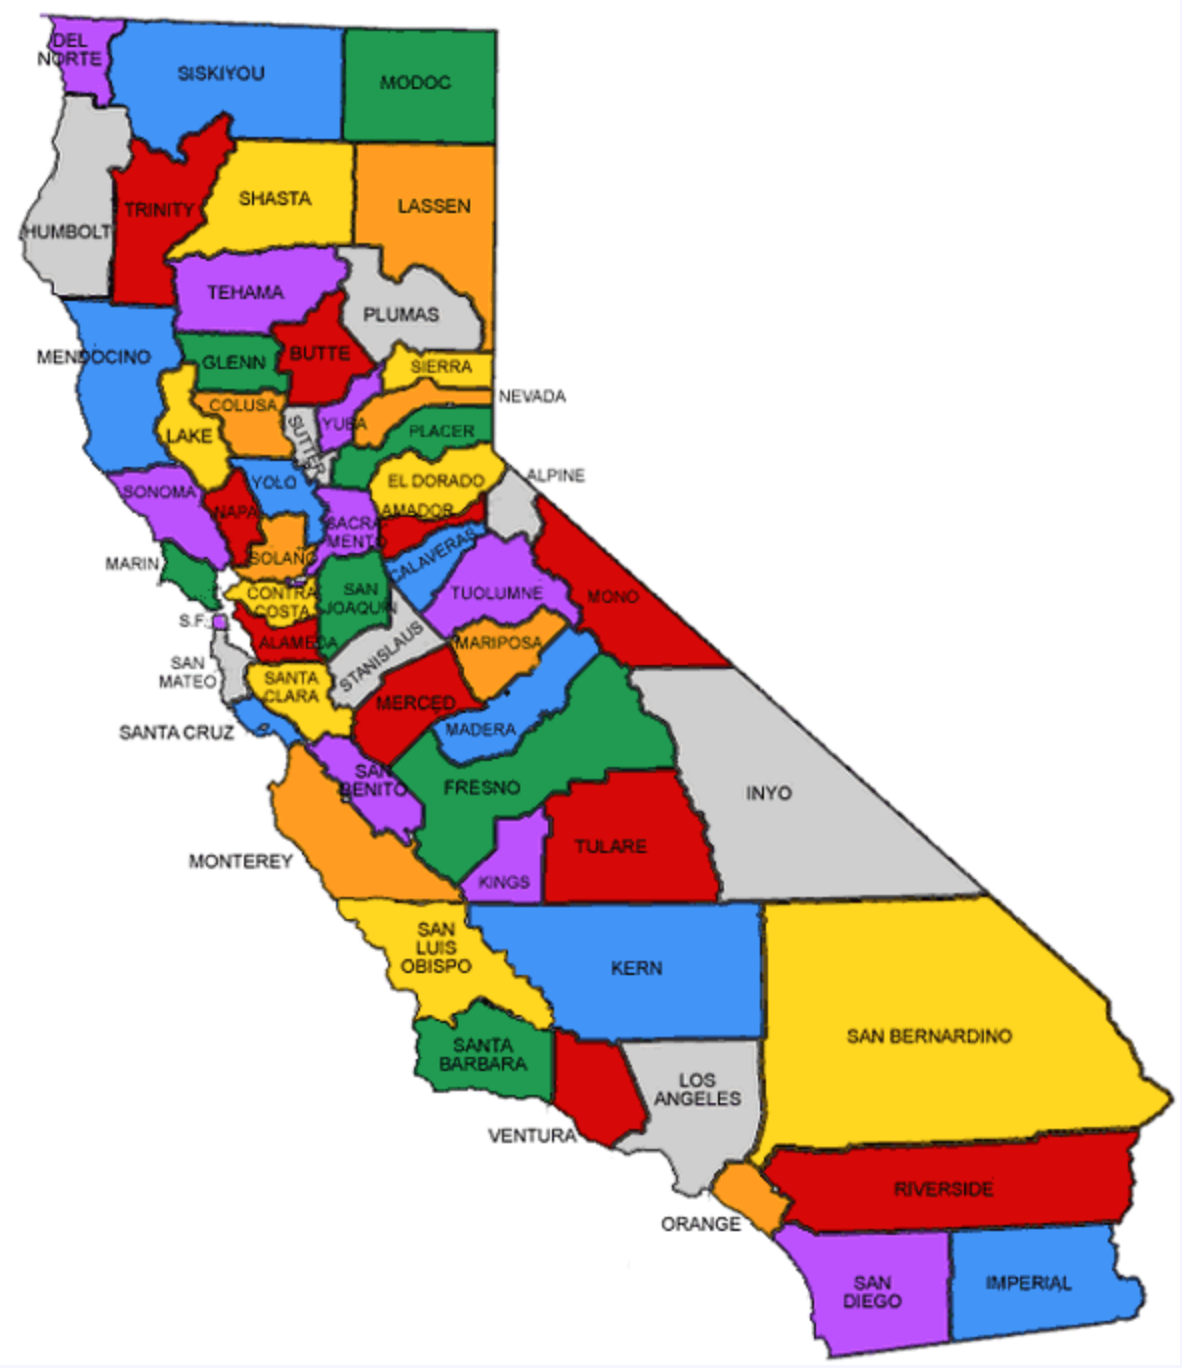

In [6]:
Image(filename='data/CA_County_map_color.png') 

In [7]:
## Let's write a simple function to display the seasonal rain pattern of a given county
def plot_county_rainfalls(target_counties, rain_df):
    for cnty in target_counties:
        small_mean_df = rain_df[rain_df.county==cnty]
        plt.plot(small_mean_df.month, small_mean_df.prob_of_rain, '-o', label=cnty)
        plt.ylim([0,.8])
    plt.legend()  

#### As you can see, there are a variety of seasonal rainfall patterns in the different counties in California

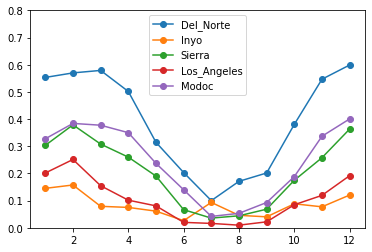

In [8]:
target_counties = ['Del_Norte', 'Inyo', 'Sierra', 'Los_Angeles', 'Modoc']
plot_county_rainfalls(target_counties, mean_by_mc_train_full)

### But counties in the same regions display similar behavior
### Here are some counties in the Northwest of the state - this is a rainy region

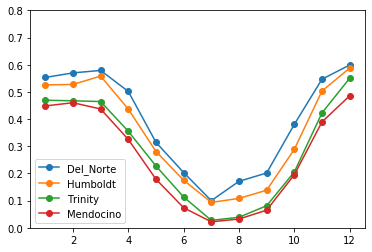

In [9]:
target_counties = ['Del_Norte', 'Humboldt', 'Trinity', 'Mendocino']
plot_county_rainfalls(target_counties, mean_by_mc_train_full)

### Here are counties in the southeast - more of a desert climate

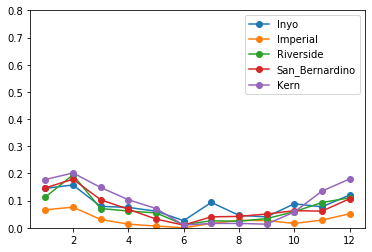

In [10]:
target_counties = ['Inyo', 'Imperial', 'Riverside', 'San_Bernardino', 'Kern']
plot_county_rainfalls(target_counties, mean_by_mc_train_full)

### In the mountains near the Nevada border

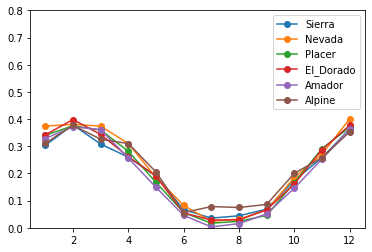

In [11]:
target_counties = ['Sierra', 'Nevada', 'Placer', 'El_Dorado', 'Amador', 'Alpine']
plot_county_rainfalls(target_counties, mean_by_mc_train_full)

### Southern Coastal counties

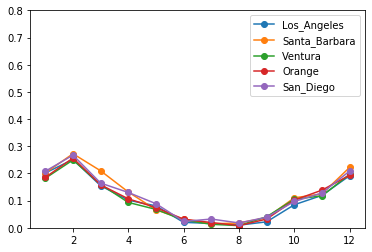

In [12]:
target_counties = ['Los_Angeles', 'Santa_Barbara', 'Ventura', 'Orange', 'San_Diego']
plot_county_rainfalls(target_counties, mean_by_mc_train_full)

### Northeastern counties

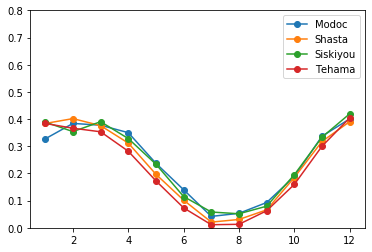

In [13]:
target_counties = ['Modoc', 'Shasta', 'Siskiyou','Tehama']
plot_county_rainfalls(target_counties, mean_by_mc_train_full)

### Though, in some cases, neighboring counties may have quite different patterns

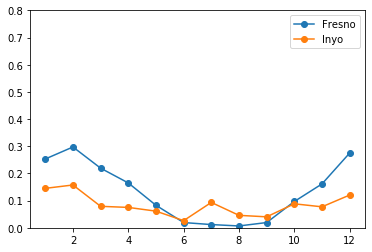

In [14]:
target_counties = ['Fresno', 'Inyo']
plot_county_rainfalls(target_counties, mean_by_mc_train_full)

## Categorical Structure

Clearly, neighboring counties tend to have similar rainfall patterns. 

Suppose, with a small amount of training data (say 500-2500 points), we wanted to predict the probability of rainfall in a given county for a given month for each of 12 x 58 = 696 month-county combinations.  Clearly it would be useful if we could use the *structure* of the counties to inform our model.

StructureBoost allows us to do precisely that.  Specifically, we can provide the model with a *graph* representing the structure of counties.  StructureBoost uses that graph to explore splits that respect the structure (in this case, geographic structure) of the variable.

### Predicting rainfall probabilities with StructureBoost

In [15]:
# We will use just county and month to predict probability of rainfall
X = df_ca_PRCP.loc[:,['county','month']]
y = df_ca_PRCP.rained.values

In [16]:
# We create a test set of size 100,000, a validation set (for early stopping) of size 20000
# X_train_big will contain the rest of the data
# but we will use relatively few of these points for training
X_trva, X_test, y_trva, y_test = train_test_split(X,y, test_size = 100000, random_state=0)
X_train_big, X_valid, y_train_big, y_valid = train_test_split(X_trva, y_trva, test_size = 20000, random_state=0)

### Define graphs

In [17]:
CA_county_graph = stb.graphs.CA_county_graph()
len(CA_county_graph.vertices), len(CA_county_graph.edges)

(58, 133)

In [18]:
# You can uncomment the next line to see the vertices and edges of this graph
#CA_county_graph.vertices, CA_county_graph.edges

In [19]:
# We also create a "cycle" graph for the months of the year
month_graph = stb.graphs.cycle_int_graph(1,12)
month_graph.edges

{frozenset({3, 4}),
 frozenset({2, 3}),
 frozenset({11, 12}),
 frozenset({9, 10}),
 frozenset({1, 2}),
 frozenset({4, 5}),
 frozenset({6, 7}),
 frozenset({8, 9}),
 frozenset({7, 8}),
 frozenset({1, 12}),
 frozenset({5, 6}),
 frozenset({10, 11})}

In [20]:
# Here, we create the feature configuration dictionary from scratch
# StructureBoost provides some tools to create these more quickly
# This is demonstrated in other notebooks...

# create the configuration for county
feature_configs_county = {}
feature_configs_county['feature_type'] = 'categorical_str'
feature_configs_county['graph'] = CA_county_graph
feature_configs_county['split_method'] = 'span_tree'
feature_configs_county['num_span_trees'] = 1

# create the configuration for month
# Since we have just a cycle graph, there are only 12*11/2 = 66 possible splits
# We use split_method = `contraction` with both `contraction_size` and `max_splits_to_search`
# set to infinity.  This means we will exhaustively search all splits into
# two connected components.  
# For bigger or denser graphs, this would be computationally infeasible
feature_configs_month = {}
feature_configs_month['feature_type'] = 'categorical_int'
feature_configs_month['graph'] = month_graph
feature_configs_month['split_method'] = 'contraction'
feature_configs_month['contraction_size'] = np.Inf
feature_configs_month['max_splits_to_search'] = np.Inf

# create the overall feature_configs dictionary
feature_configs = {}
feature_configs['county'] = feature_configs_county
feature_configs['month'] = feature_configs_month

feature_configs

{'county': {'feature_type': 'categorical_str',
  'graph': <graphs.graph_undirected at 0x13e80fe80>,
  'split_method': 'span_tree',
  'num_span_trees': 1},
 'month': {'feature_type': 'categorical_int',
  'graph': <graphs.graph_undirected at 0x1357f8b38>,
  'split_method': 'contraction',
  'contraction_size': inf,
  'max_splits_to_search': inf}}

In [21]:
# Here we create the (small) training set that we will actually use
num_train_pts = 1000
X_train = X_train_big.iloc[:num_train_pts,:]
y_train = y_train_big[:num_train_pts]

In [22]:
# Define and fit the a StructureBoost model
stboost_CA = stb.StructureBoost(num_trees = 1500, learning_rate=.02, feature_configs=feature_configs, 
                                 max_depth=2, mode='classification')

# We use early stopping: we evaluate every 20 iterations
# and stop if we are worse than we were 2 steps before (i.e. 40 iterations before) 
stboost_CA.fit(X_train, y_train, eval_set = ((X_valid, y_valid)), early_stop_past_steps=2, eval_freq=20)

i=0, eval_set_log_loss = 0.3012095728512144
i=20, eval_set_log_loss = 0.28211427145130236
i=40, eval_set_log_loss = 0.27254791799250044
i=60, eval_set_log_loss = 0.2658834639608055
i=80, eval_set_log_loss = 0.26413436703893745
i=100, eval_set_log_loss = 0.26014040300808244
i=120, eval_set_log_loss = 0.25960590889120305
i=140, eval_set_log_loss = 0.26046512791750076
Stopping early: curr_loss of 0.26046512791750076
                                        exceeds compare_loss of 0.26014040300808244


In [23]:
# Get predictions - `predict` always returns a 1-d vector of positive probabilities
# `predict_proba` will return an n x 2 matrix of class probabilities as in other packages
pred_probs_stb = stboost_CA.predict(X_test)

In [24]:
# Evaluate the log_loss and AUROC on the test set
log_loss(y_test, pred_probs_stb), roc_auc_score(y_test, pred_probs_stb)

(0.4094880002024634, 0.7535072572407965)

In [25]:
# Define a simple function to compare the model predictions for a county with the "actual" values
def compare_model_to_actual(target_county, model, rain_df):
    tempdf = pd.DataFrame()
    tempdf['county'] = [target_county]*12
    tempdf['month'] = np.arange(1,13)
    plt.plot(np.arange(1,13), model.predict_proba(tempdf)[:,1], '-o', label=target_county+'_pred')
    plt.legend()
    plot_county_rainfalls([target_county], rain_df)

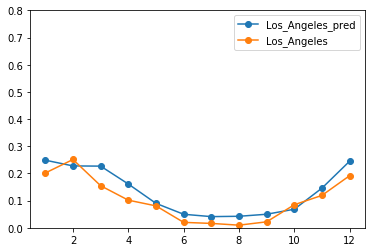

In [26]:
compare_model_to_actual('Los_Angeles', stboost_CA, mean_by_mc_train_full)

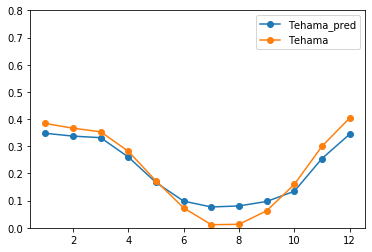

In [27]:
compare_model_to_actual('Tehama', stboost_CA, mean_by_mc_train_full)

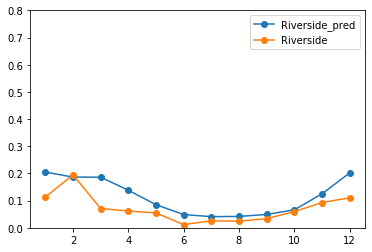

In [28]:
compare_model_to_actual('Riverside', stboost_CA, mean_by_mc_train_full)

In [29]:
# As you can see, we have very few data points for any particular county-month combination
# and many are completely absent
X_train[X_train.county=='Inyo'].month.value_counts().sort_index()

1     2
2     3
3     3
5     3
6     3
7     2
11    1
Name: month, dtype: int64

### Comparison with CatBoost
We fit a comparable CatBoost model and compare the results.  This can be skipped if CatBoost is not installed

In [30]:
import catboost as cb

In [31]:
# Define and fit a comparable CatBoost model
cat_features = ['county']
cb_model = cb.CatBoostClassifier(iterations=1500, early_stopping_rounds=40, max_depth=2,
                             learning_rate=.02, cat_features=cat_features)

cb_model.fit(X_train, y_train, cat_features, eval_set=(X_valid, y_valid), verbose=20)

0:	learn: 0.6828678	test: 0.6825302	best: 0.6825302 (0)	total: 58.1ms	remaining: 1m 27s
20:	learn: 0.5425566	test: 0.5376233	best: 0.5376233 (20)	total: 91ms	remaining: 6.41s
40:	learn: 0.4925150	test: 0.4852833	best: 0.4852833 (40)	total: 111ms	remaining: 3.95s
60:	learn: 0.4689096	test: 0.4604981	best: 0.4604981 (60)	total: 131ms	remaining: 3.1s
80:	learn: 0.4558834	test: 0.4472747	best: 0.4472747 (80)	total: 165ms	remaining: 2.88s
100:	learn: 0.4489550	test: 0.4409799	best: 0.4409799 (100)	total: 186ms	remaining: 2.57s
120:	learn: 0.4431057	test: 0.4356924	best: 0.4356924 (120)	total: 205ms	remaining: 2.34s
140:	learn: 0.4386627	test: 0.4316832	best: 0.4316832 (140)	total: 224ms	remaining: 2.16s
160:	learn: 0.4358354	test: 0.4293471	best: 0.4293471 (160)	total: 244ms	remaining: 2.03s
180:	learn: 0.4336838	test: 0.4280871	best: 0.4280871 (180)	total: 265ms	remaining: 1.93s
200:	learn: 0.4319674	test: 0.4271935	best: 0.4271935 (200)	total: 287ms	remaining: 1.85s
220:	learn: 0.4301889	

In [32]:
# Make the predictions
pred_probs_cb = cb_model.predict_proba(X_test)[:,1]

In [33]:
# Evaluate on test set
log_loss(y_test, pred_probs_cb), roc_auc_score(y_test, pred_probs_cb)

(0.41898726847540463, 0.7361842880375318)

In [34]:
# StructureBoost results for comparison
log_loss(y_test, pred_probs_stb), roc_auc_score(y_test, pred_probs_stb)

(0.4094880002024634, 0.7535072572407965)

### Comparison plots on individual counties
Here we plot predicted vs actual for several counties, for both the CatBoost and StructureBoost models.  Since StructureBoost can leverage  geographical knowledge, it is able to give more accurate predictions.

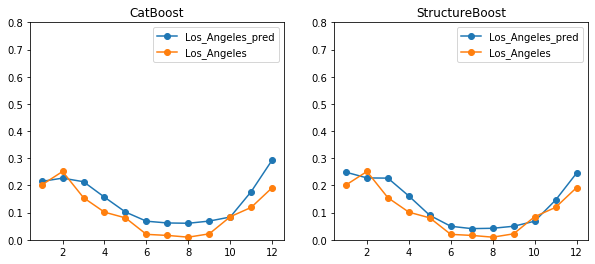

In [35]:
plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.title('CatBoost')
compare_model_to_actual('Los_Angeles', cb_model, mean_by_mc_train_full)

plt.subplot(1,2,2)
plt.title('StructureBoost')
compare_model_to_actual('Los_Angeles', stboost_CA, mean_by_mc_train_full)

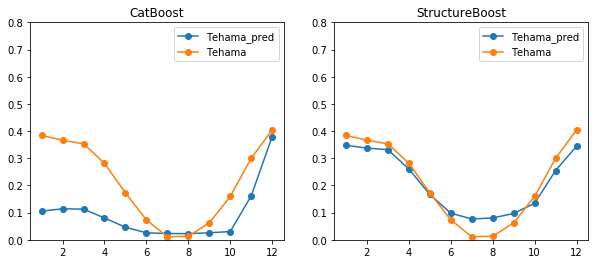

In [36]:
plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.title('CatBoost')
compare_model_to_actual('Tehama', cb_model, mean_by_mc_train_full)

plt.subplot(1,2,2)
plt.title('StructureBoost')
compare_model_to_actual('Tehama', stboost_CA, mean_by_mc_train_full)

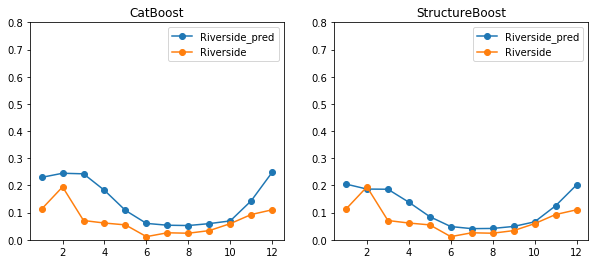

In [37]:
plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.title('CatBoost')
compare_model_to_actual('Riverside', cb_model, mean_by_mc_train_full)

plt.subplot(1,2,2)
plt.title('StructureBoost')
compare_model_to_actual('Riverside', stboost_CA, mean_by_mc_train_full)

## Unseen Categorical Values
Another advantage of exploiting categorical structure is that you can make better predictions on categorical values that are completely unseen in the training data.  In the following, we will omit data from a few counties from our training set, and then see how well the different models do in predicting the precipitation patterns in the absence of the specific data.

In [38]:
# Create a list of counties to leave out, and remove those data points from both training and validation sets
counties_to_omit = ['Humboldt', 'Sierra', 'Riverside']
X_train_omit = X_train[np.logical_not(X_train.county.isin(counties_to_omit))]
y_train_omit = y_train[np.logical_not(X_train.county.isin(counties_to_omit))]

X_valid_omit = X_valid[np.logical_not(X_valid.county.isin(counties_to_omit))]
y_valid_omit = y_valid[np.logical_not(X_valid.county.isin(counties_to_omit))]


In [39]:
# Define and fit the StructureBoost model
stboost_CA_2 = stb.StructureBoost(num_trees = 1500, learning_rate=.02, feature_configs=feature_configs, 
                                 max_depth=2, mode='classification')

stboost_CA_2.fit(X_train_omit, y_train_omit, eval_set = ((X_valid_omit, y_valid_omit)), early_stop_past_steps=2, eval_freq=20)

i=0, eval_set_log_loss = 0.29580353226082795
i=20, eval_set_log_loss = 0.27748712037318024
i=40, eval_set_log_loss = 0.26664398740076073
i=60, eval_set_log_loss = 0.26084218898262607
i=80, eval_set_log_loss = 0.25679909669840884
i=100, eval_set_log_loss = 0.2565123174808635
i=120, eval_set_log_loss = 0.2542139284959072
i=140, eval_set_log_loss = 0.25459815957102416
i=160, eval_set_log_loss = 0.2556087952887554
Stopping early: curr_loss of 0.2556087952887554
                                        exceeds compare_loss of 0.2542139284959072


In [40]:
# Predict the probabilities
pred_probs_stb_2 = stboost_CA_2.predict(X_test)

In [41]:
# Calculate the log_loss and AUROC on the test set
log_loss(y_test, pred_probs_stb_2), roc_auc_score(y_test, pred_probs_stb_2)

(0.40882462613405174, 0.7551113769505859)

In [42]:
# Compare to the previous StructureBoost that saw all counties
log_loss(y_test, pred_probs_stb), roc_auc_score(y_test, pred_probs_stb)

(0.4094880002024634, 0.7535072572407965)

In [43]:
# Fit a comparable CatBoost model
cat_features = ['county']
cb_model_2 = cb.CatBoostClassifier(iterations=1500, early_stopping_rounds=40, max_depth=2,
                             learning_rate=.02, cat_features=cat_features)

cb_model_2.fit(X_train_omit, y_train_omit, cat_features, eval_set=(X_valid_omit, y_valid_omit), verbose=20)

0:	learn: 0.6823157	test: 0.6817614	best: 0.6817614 (0)	total: 3.38ms	remaining: 5.07s
20:	learn: 0.5382623	test: 0.5318331	best: 0.5318331 (20)	total: 37.2ms	remaining: 2.62s
40:	learn: 0.4838818	test: 0.4753977	best: 0.4753977 (40)	total: 66.3ms	remaining: 2.36s
60:	learn: 0.4638700	test: 0.4550476	best: 0.4550476 (60)	total: 92.4ms	remaining: 2.18s
80:	learn: 0.4532462	test: 0.4442591	best: 0.4442591 (80)	total: 114ms	remaining: 1.99s
100:	learn: 0.4447505	test: 0.4362675	best: 0.4362675 (100)	total: 133ms	remaining: 1.84s
120:	learn: 0.4404089	test: 0.4320624	best: 0.4320624 (120)	total: 154ms	remaining: 1.75s
140:	learn: 0.4368539	test: 0.4292480	best: 0.4292480 (140)	total: 175ms	remaining: 1.69s
160:	learn: 0.4332406	test: 0.4262207	best: 0.4262207 (160)	total: 198ms	remaining: 1.65s
180:	learn: 0.4309758	test: 0.4248256	best: 0.4248256 (180)	total: 220ms	remaining: 1.6s
200:	learn: 0.4283383	test: 0.4233707	best: 0.4232941 (199)	total: 239ms	remaining: 1.54s
220:	learn: 0.42646

In [44]:
# Make predictions
pred_probs_cb_2 = cb_model_2.predict_proba(X_test)[:,1]

In [45]:
# Evaluate results
log_loss(y_test, pred_probs_cb_2), roc_auc_score(y_test, pred_probs_cb_2)

(0.42614000525440643, 0.7202519119571755)

In [46]:
# Compare to StructureBoost
log_loss(y_test, pred_probs_stb_2), roc_auc_score(y_test, pred_probs_stb_2)

(0.40882462613405174, 0.7551113769505859)

### Compare predictions on the unseen counties

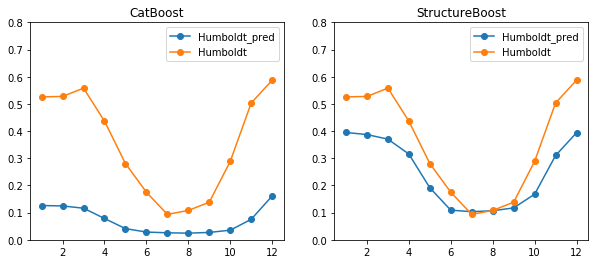

In [47]:
plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.title('CatBoost')
compare_model_to_actual('Humboldt', cb_model_2, mean_by_mc_train_full)

plt.subplot(1,2,2)
plt.title('StructureBoost')
compare_model_to_actual('Humboldt', stboost_CA_2, mean_by_mc_train_full)

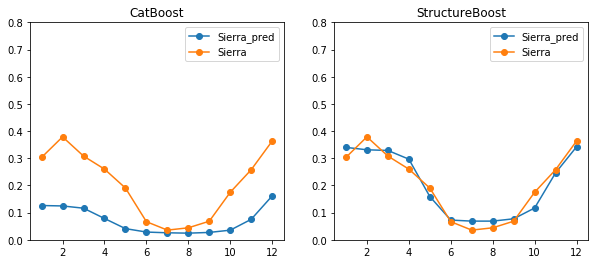

In [48]:
plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.title('CatBoost')
compare_model_to_actual('Sierra', cb_model_2, mean_by_mc_train_full)

plt.subplot(1,2,2)
plt.title('StructureBoost')
compare_model_to_actual('Sierra', stboost_CA_2, mean_by_mc_train_full)

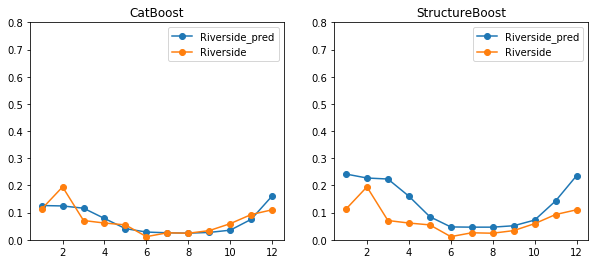

In [49]:
plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.title('CatBoost')
compare_model_to_actual('Riverside', cb_model_2, mean_by_mc_train_full)

plt.subplot(1,2,2)
plt.title('StructureBoost')
compare_model_to_actual('Riverside', stboost_CA_2, mean_by_mc_train_full)

Since CatBoost has no knowledge of the geographical structure of the counties, it makes the same prediction for all 3 unseen counties.  StructureBoost is able to appropriately average over the neighboring counties to yield better predictions in the absence of direct data.

